In [44]:
!pip install ydata-profiling


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
!pip install wandb


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from ydata_profiling import ProfileReport
import warnings

In [47]:
%matplotlib inline
warnings.filterwarnings('ignore')

## 1 EDA pipeline

In [48]:
def load_data_from_artifact(project, artifact_name, entity='ngocnhi-p4work-national-economics-university'):
    wandb.login()
    run = wandb.init(project=project, entity=entity, job_type='eda')
    artifact = run.use_artifact(artifact_name)
    artifact_dir = artifact.download()
    csv_path = os.path.join(artifact_dir, 'raw_data.csv')
    df = pd.read_csv(csv_path)
    print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns.")
    return df, run

In [49]:
def generate_profile_report(df, report_path='eda_report.html'):
    profile = ProfileReport(df, title="EDA Report", explorative=True)
    profile.to_file(report_path)
    print(f"Report saved to {report_path}")
    return report_path

In [50]:
def log_eda_report_to_wandb(run, report_path):
    run.log({"eda_report": wandb.Html(report_path)})
    run.finish()
    print("EDA report logged to W&B")

In [51]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    iqr = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low, up = outlier_thresholds(dataframe, col_name)
    return dataframe[(dataframe[col_name] < low) | (dataframe[col_name] > up)].any(axis=None)

def replace_with_thresholds(dataframe, col_name):
    low, up = outlier_thresholds(dataframe, col_name)
    dataframe.loc[dataframe[col_name] < low, col_name] = low
    dataframe.loc[dataframe[col_name] > up, col_name] = up

In [52]:
# === RUN EDA PIPELINE ===
PROJECT = 'diabetes'
ARTIFACT_NAME = 'ngocnhi-p4work-national-economics-university/diabetes/raw_data.csv:latest'

# Step 1: Load data
df, run = load_data_from_artifact(PROJECT, ARTIFACT_NAME)

# Step 2: Generate profiling report
report_path = generate_profile_report(df)

# Step 3: Log to W&B
log_eda_report_to_wandb(run, report_path)

# Step 4: Handle outliers
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)
print("Outlier treatment completed.")

wandb:   1 of 1 files downloaded.  


Loaded 768 rows and 9 columns.


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


Report saved to eda_report.html


EDA report logged to W&B
Outlier treatment completed.


## 2. EDA Manually

### 2.1 Information about data

In [53]:
print ("Shape of data {}" . format (df.shape))
print ("Number of rows: {}" . format (df.shape [0]))
print ("Number of columns: {}" . format (df.shape [1]))
print("Parameter are: ",df.columns)

Shape of data (768, 9)
Number of rows: 768
Number of columns: 9
Parameter are:  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


### 2.2 Missing values

In [54]:
#check missing value 
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### 2.3 Duplicate

In [55]:
#Check duplicate 
print ("Duplicate values in data set are:" , df.duplicated().sum())

Duplicate values in data set are: 0


In [56]:
#Unique categories of Categorical Variables
print(df['Outcome'].unique())

[1 0]


### 2.4 Capture of Numerical and Category Variables

In [57]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [58]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [59]:
cat_cols

['Outcome']

In [60]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

### 2.5 Correlation

In [61]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073091,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331189,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.090316,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.440258,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073091,0.331189,0.090316,0.440258,1.000000,0.199825,0.186246,-0.045345,0.130020
BMI,0.017683,0.221071,0.281805,0.392573,0.199825,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.186246,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.045345,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130020,0.292695,0.173844,0.238356,1.000000


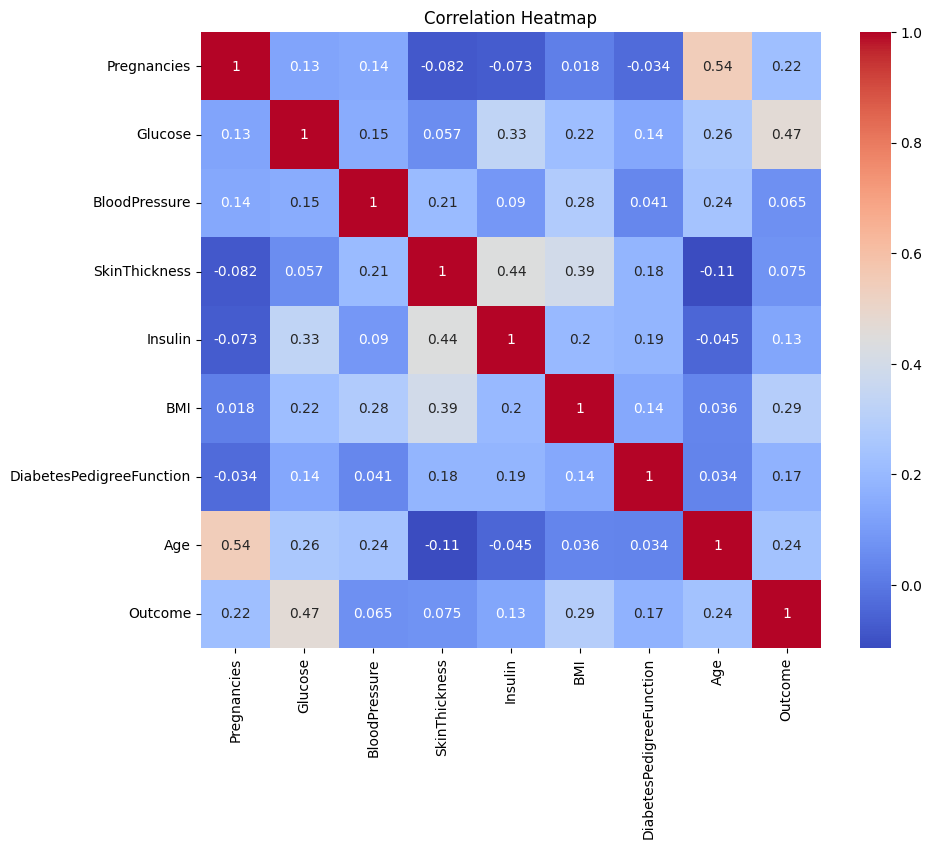

In [62]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### 2.6 Visualization

<Figure size 1500x1500 with 0 Axes>

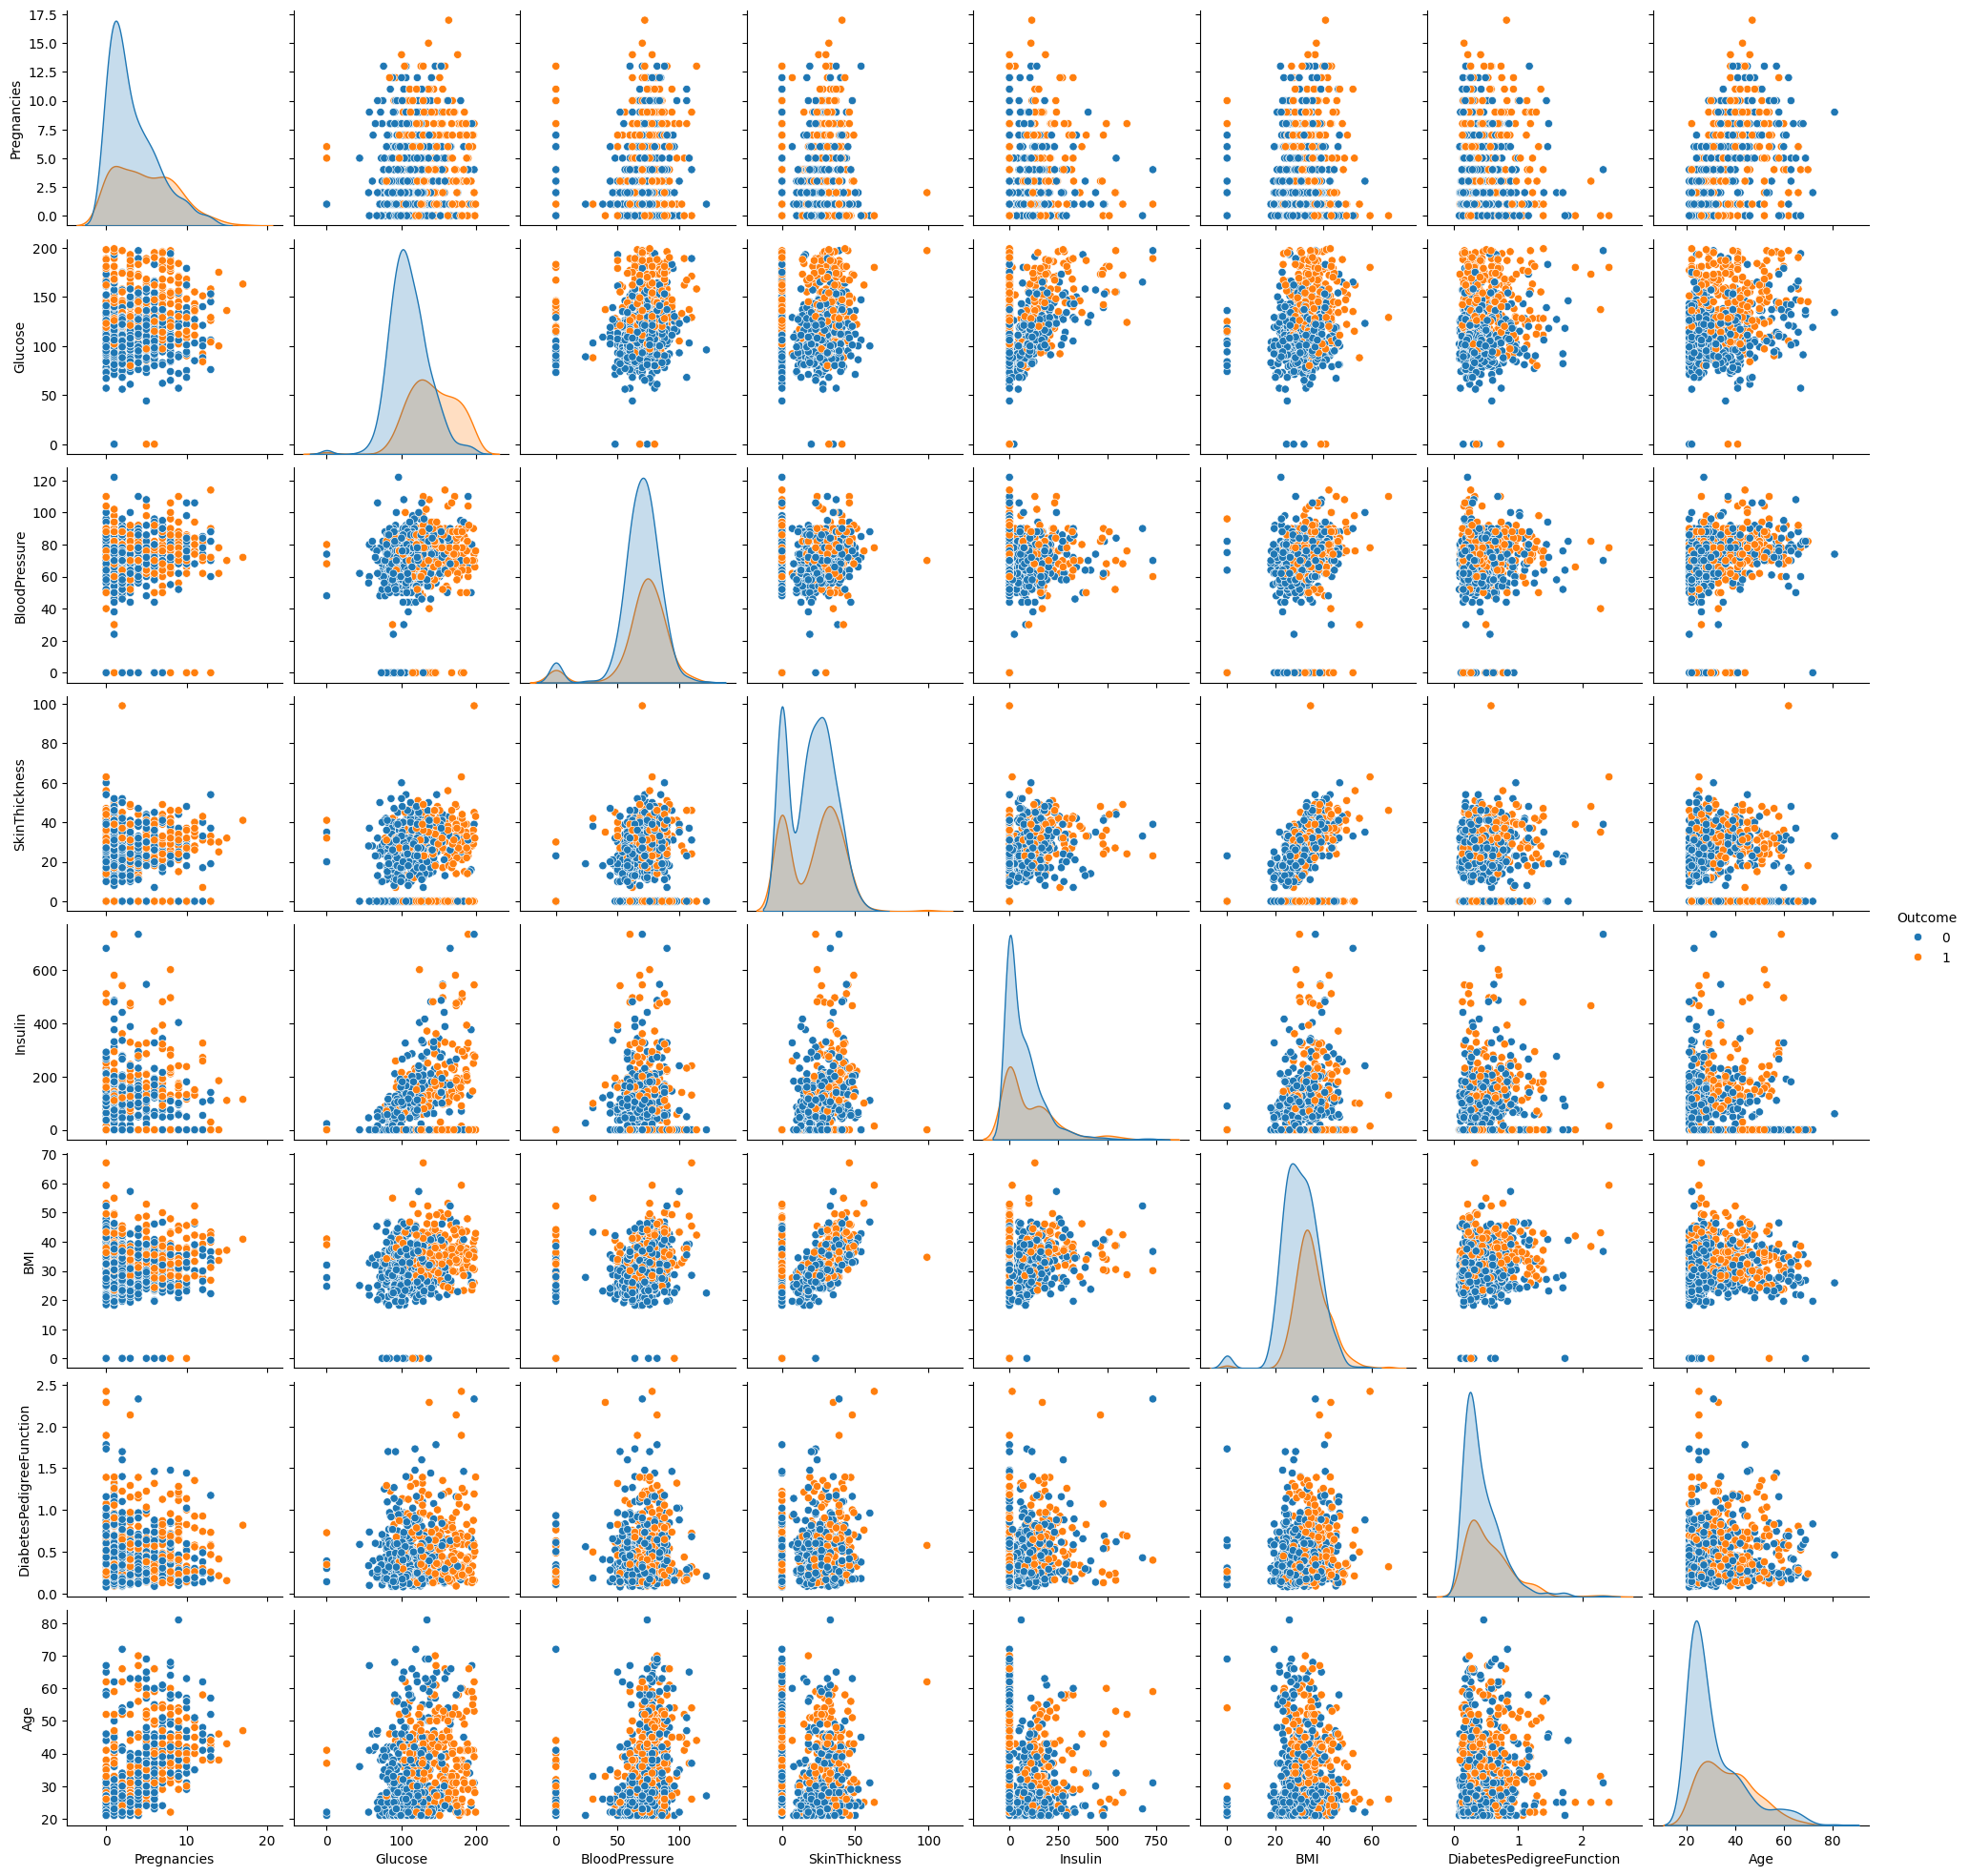

In [63]:
plt.figure(figsize=(15,15))
sns.pairplot(df,hue='Outcome')
plt.show()

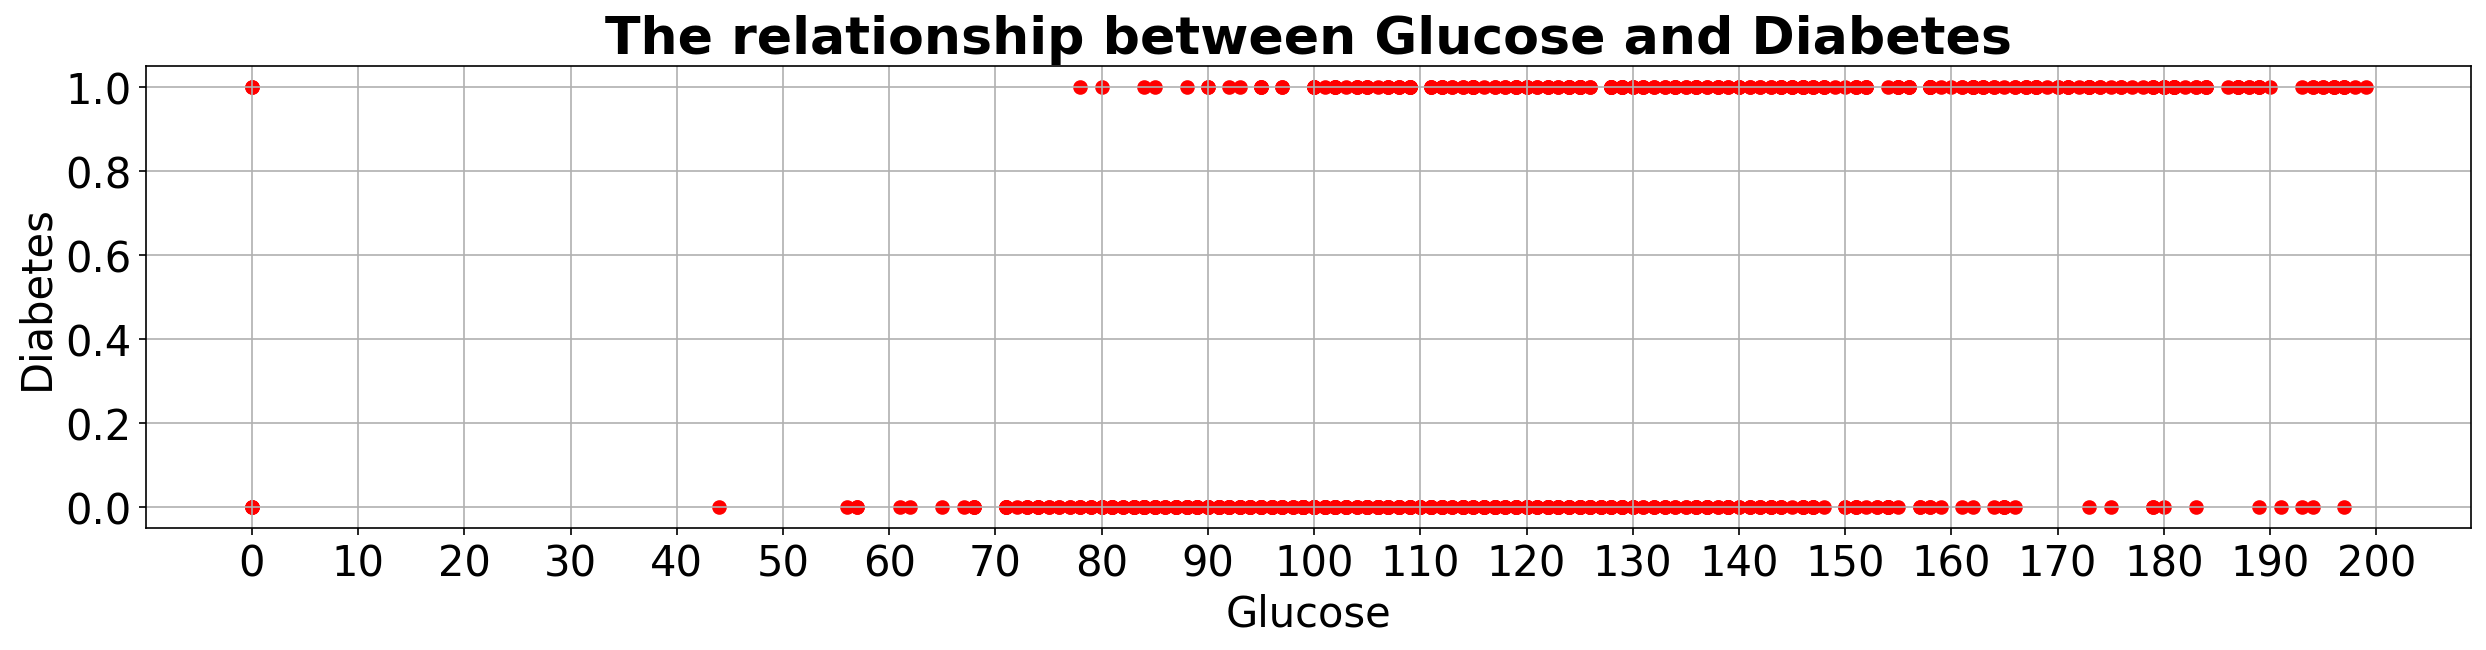

In [64]:
plt.figure(figsize = [20, 4] , dpi = 150)
plt.scatter (df["Glucose"] , df["Outcome"] , color = "red")
plt.title ("The relationship between Glucose and Diabetes" , weight='bold', fontsize = 25)
plt.xticks (range (0 , 205 , 10), fontsize = 20)
plt.yticks (fontsize = 20)
plt.xlabel ('Glucose', fontsize = 20 )
plt.ylabel ('Diabetes' , fontsize = 20)
plt.grid ()
plt.show ()

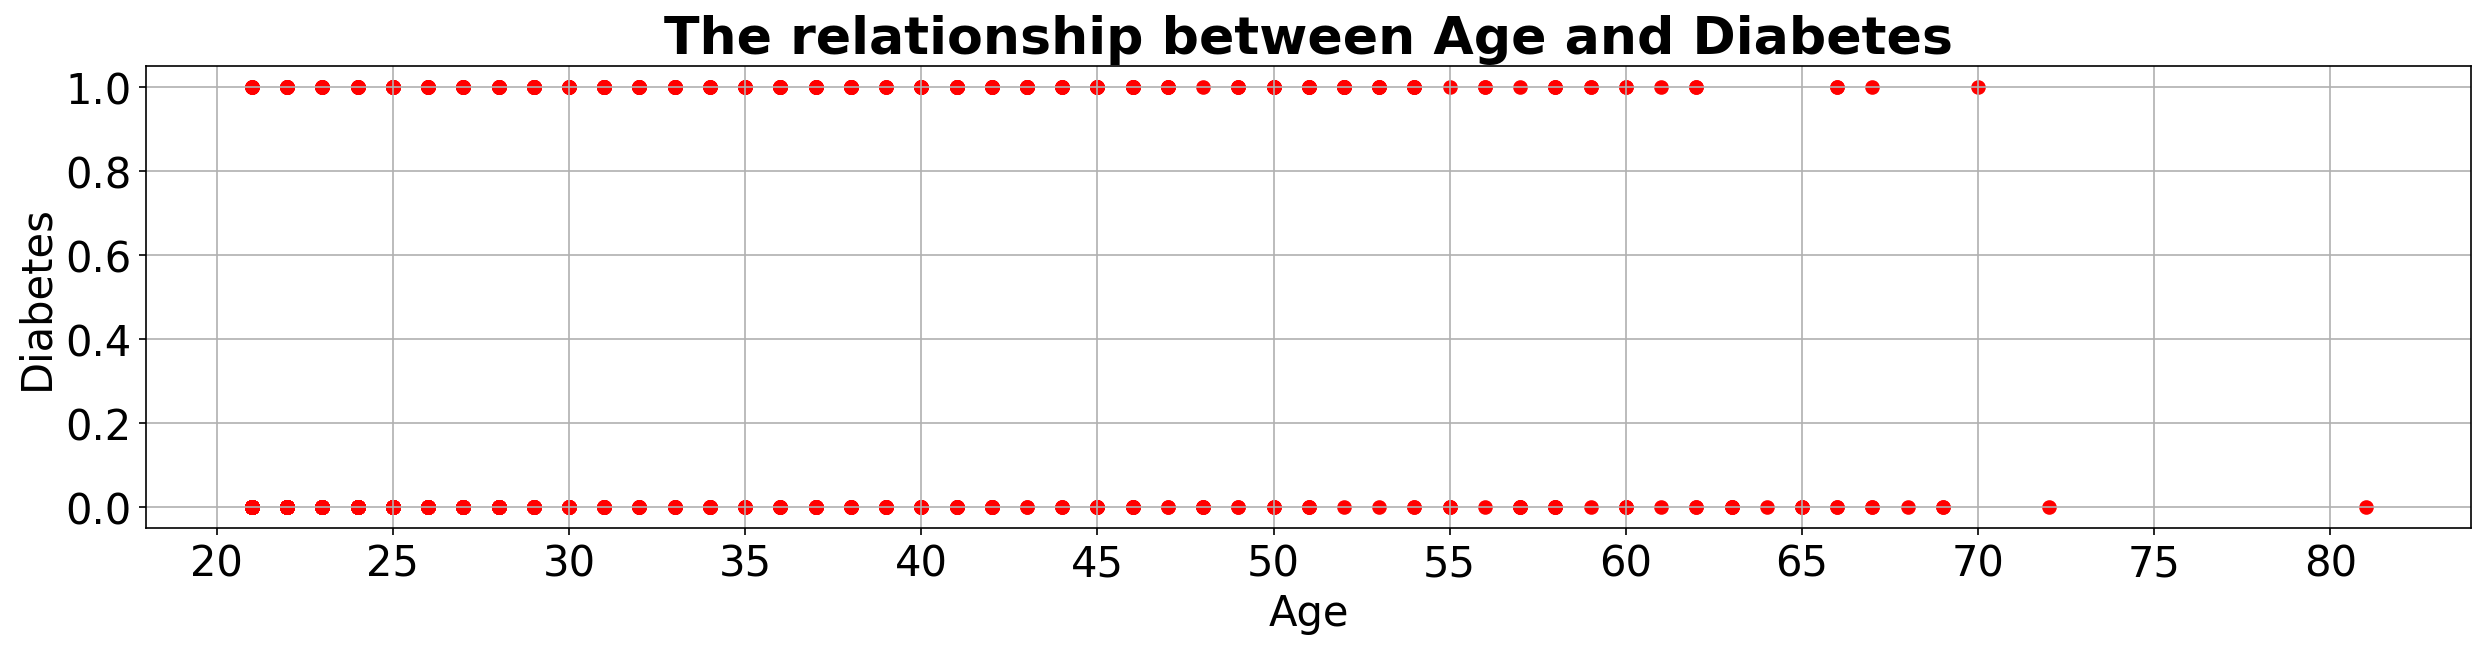

In [65]:
plt.figure(figsize = [20, 4] , dpi = 150)
plt.scatter (df["Age"] , df["Outcome"] , color = "red")
plt.title ("The relationship between Age and Diabetes" , weight='bold', fontsize = 25)
plt.xticks (range (20 , 85 , 5), fontsize = 20)
plt.yticks (fontsize = 20)
plt.xlabel ('Age', fontsize = 20 )
plt.ylabel ('Diabetes' , fontsize = 20)
plt.grid ()
plt.show ()

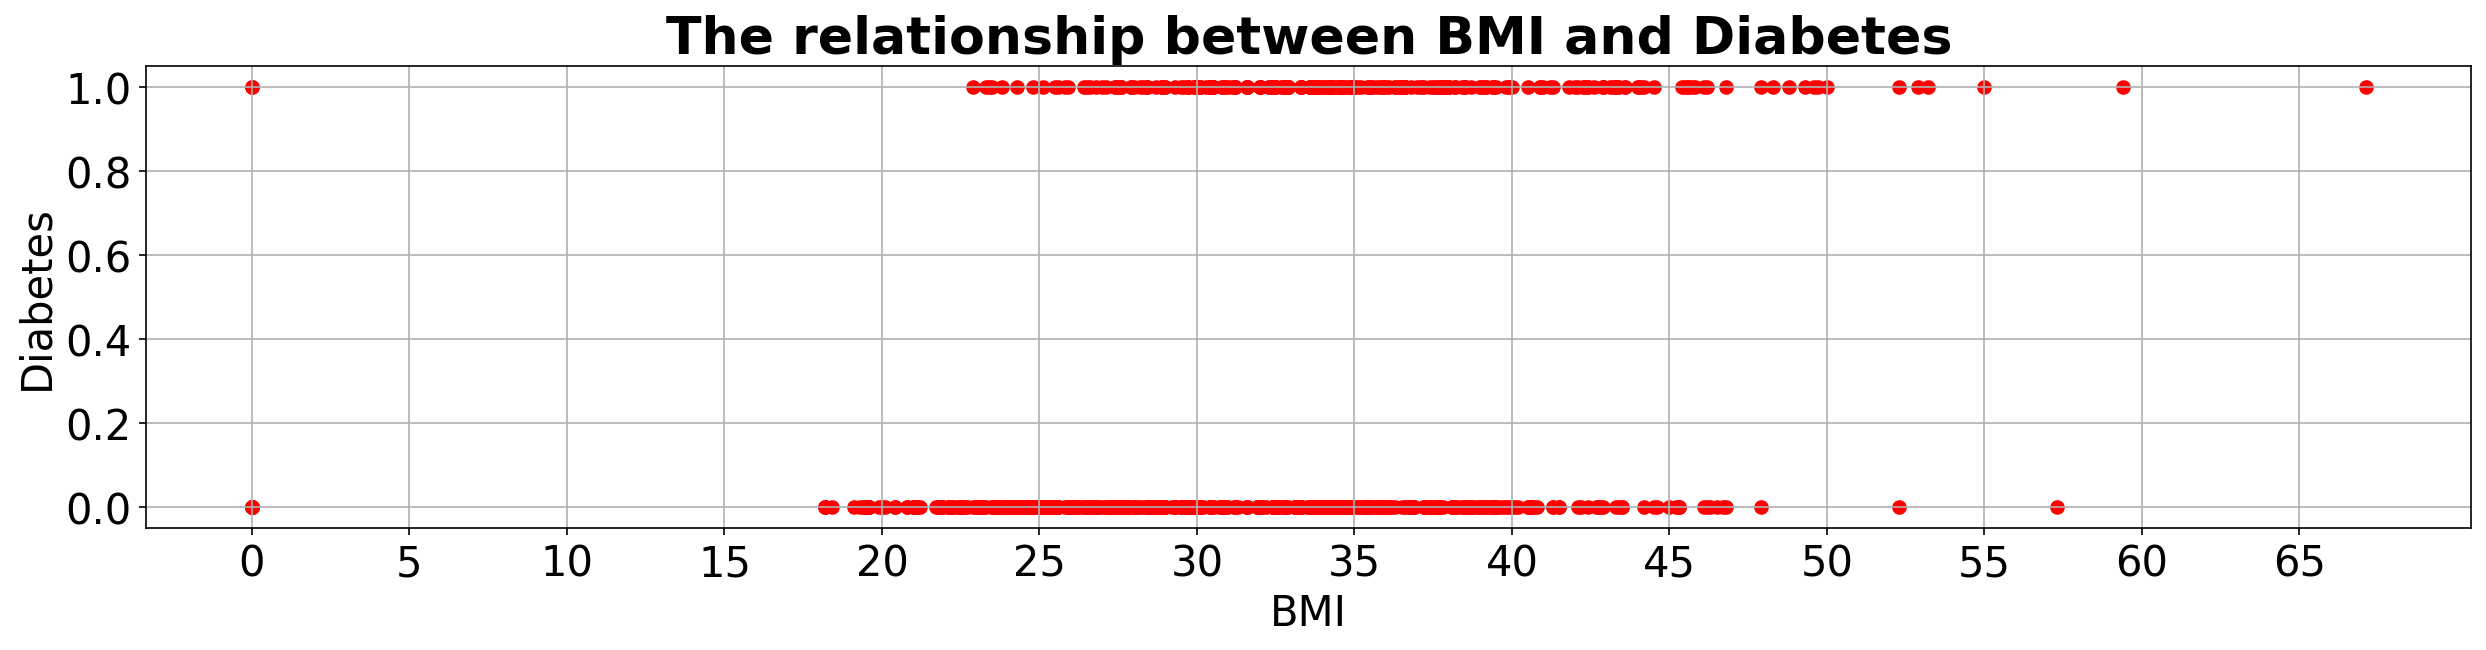

In [66]:
plt.figure(figsize = [20, 4] , dpi = 150)
plt.scatter (df["BMI"] , df["Outcome"] , color = "red")
plt.title ("The relationship between BMI and Diabetes" , weight = 'bold', fontsize = 25)
plt.xticks (range (0 , 70 , 5) , fontsize=20)
plt.yticks (fontsize = 20)
plt.xlabel ('BMI', fontsize = 20 )
plt.ylabel ('Diabetes' , fontsize = 20)
plt.grid ()
plt.show ()

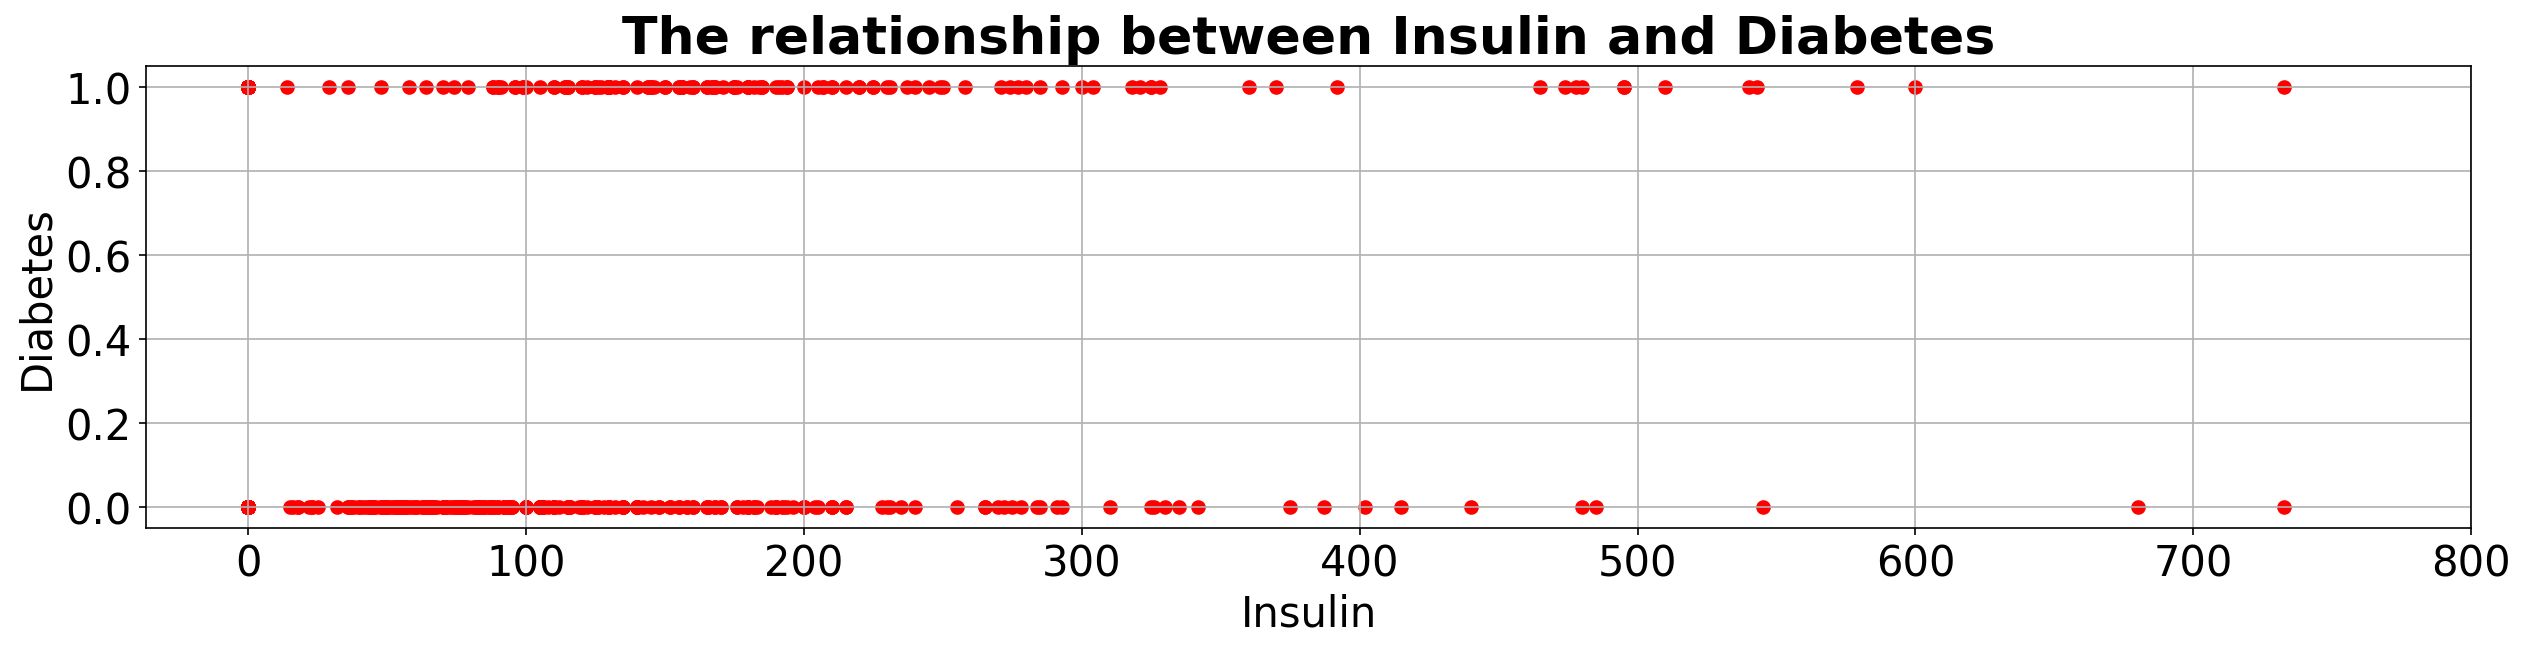

In [67]:
plt.figure(figsize = [20, 4] , dpi = 150)
plt.scatter (df["Insulin"] , df["Outcome"] , color = "red")
plt.title ("The relationship between Insulin and Diabetes" , weight = 'bold', fontsize = 25)
plt.xticks (range (0 , 900 , 100) , fontsize = 20)
plt.yticks (fontsize = 20)
plt.xlabel ('Insulin', fontsize = 20 )
plt.ylabel ('Diabetes' , fontsize = 20)
plt.grid ()
plt.show ()

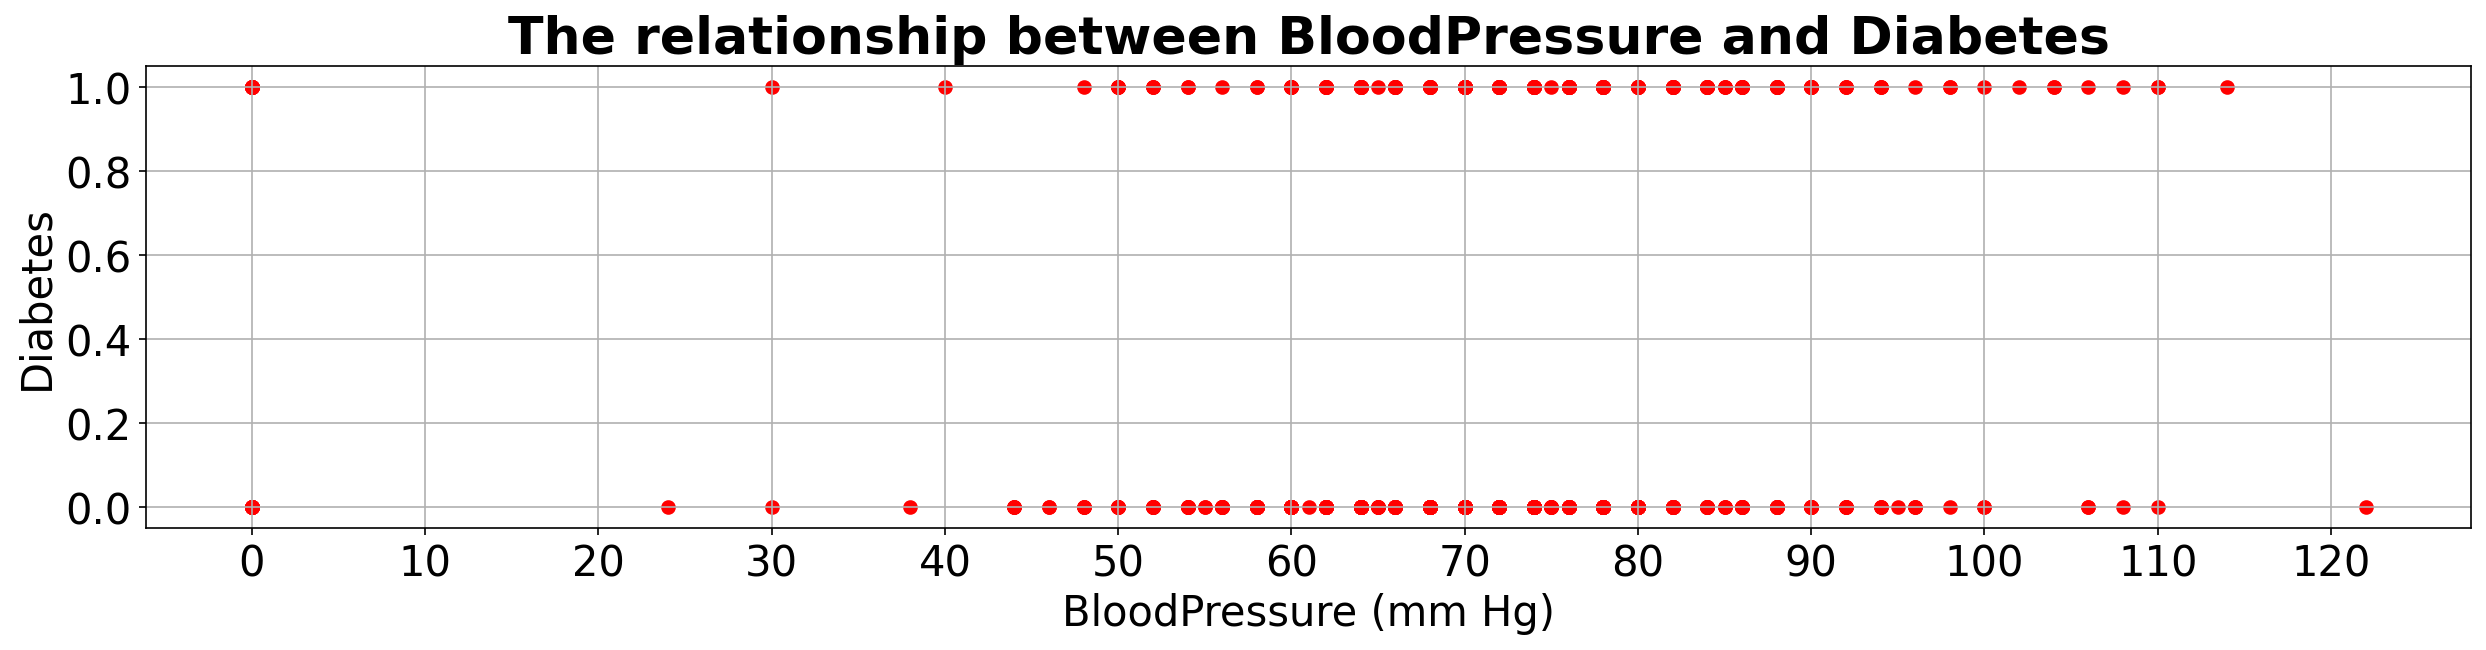

In [68]:
plt.figure(figsize = [20, 4] , dpi = 150)
plt.scatter (df["BloodPressure"] , df["Outcome"] , color = "red")
plt.title ("The relationship between BloodPressure and Diabetes" , weight = 'bold', fontsize = 25)
plt.xticks (range (0 , 125 , 10) , fontsize = 20)
plt.yticks (fontsize = 20)
plt.xlabel ('BloodPressure (mm Hg)', fontsize = 20)
plt.ylabel ('Diabetes' , fontsize = 20)
plt.grid ()
plt.show ()

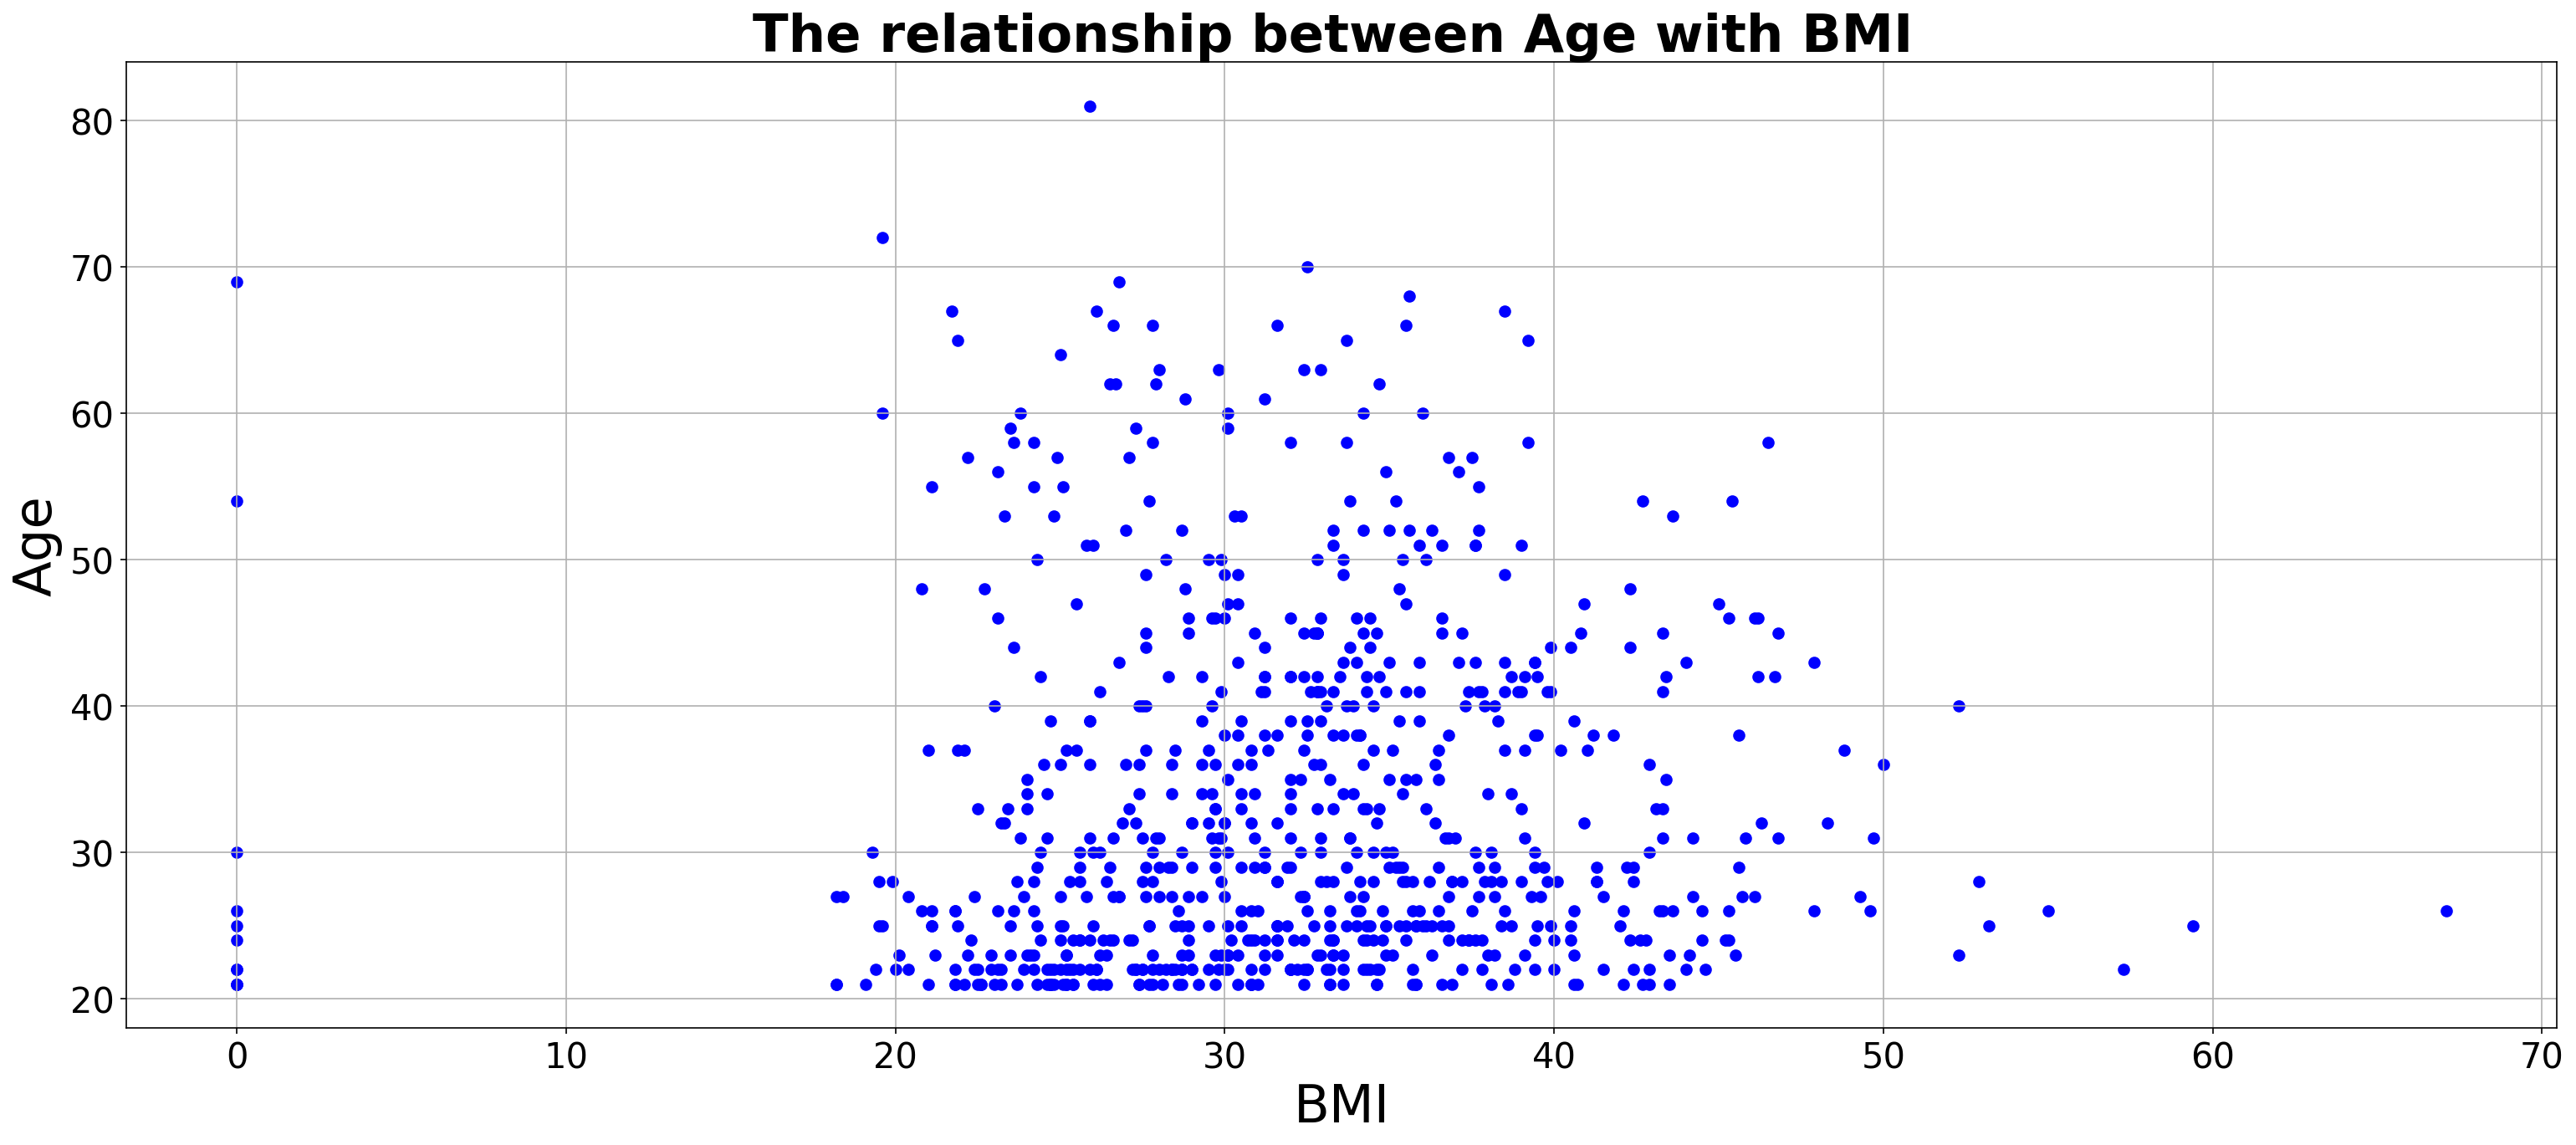

In [69]:
plt.figure(figsize = [25, 10] , dpi = 150)
plt.scatter (df["BMI"] , df["Age"] , color = "blue")
plt.title ("The relationship between Age with BMI " , weight = 'bold', fontsize = 30)
plt.xticks (range (0 , 80 , 10) , fontsize = 20)
plt.yticks (range (20 , 90 , 10) , fontsize = 20)
plt.xlabel ('BMI', fontsize = 30 )
plt.ylabel ('Age' , fontsize = 30)
plt.grid ()
plt.show ()

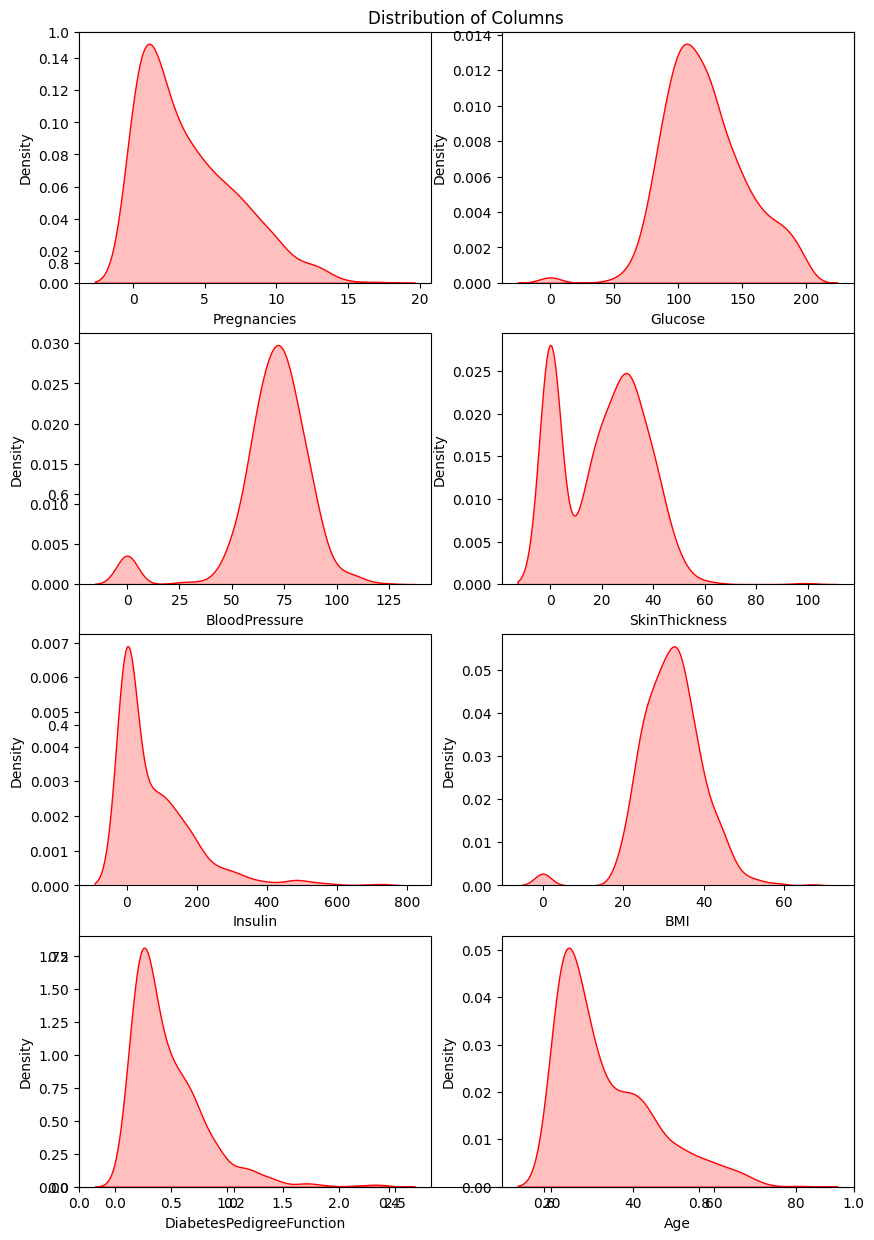

In [70]:
# loop over columns to show its distribution
plt.figure(figsize=(10,15))
plt.title('Distribution of Columns')
for i,col in zip(range(1,len(df.columns)),df.columns) :
    plt.subplot(4,2,i)
    sns.kdeplot(df[col] , fill=True , color='red' )
plt.show()

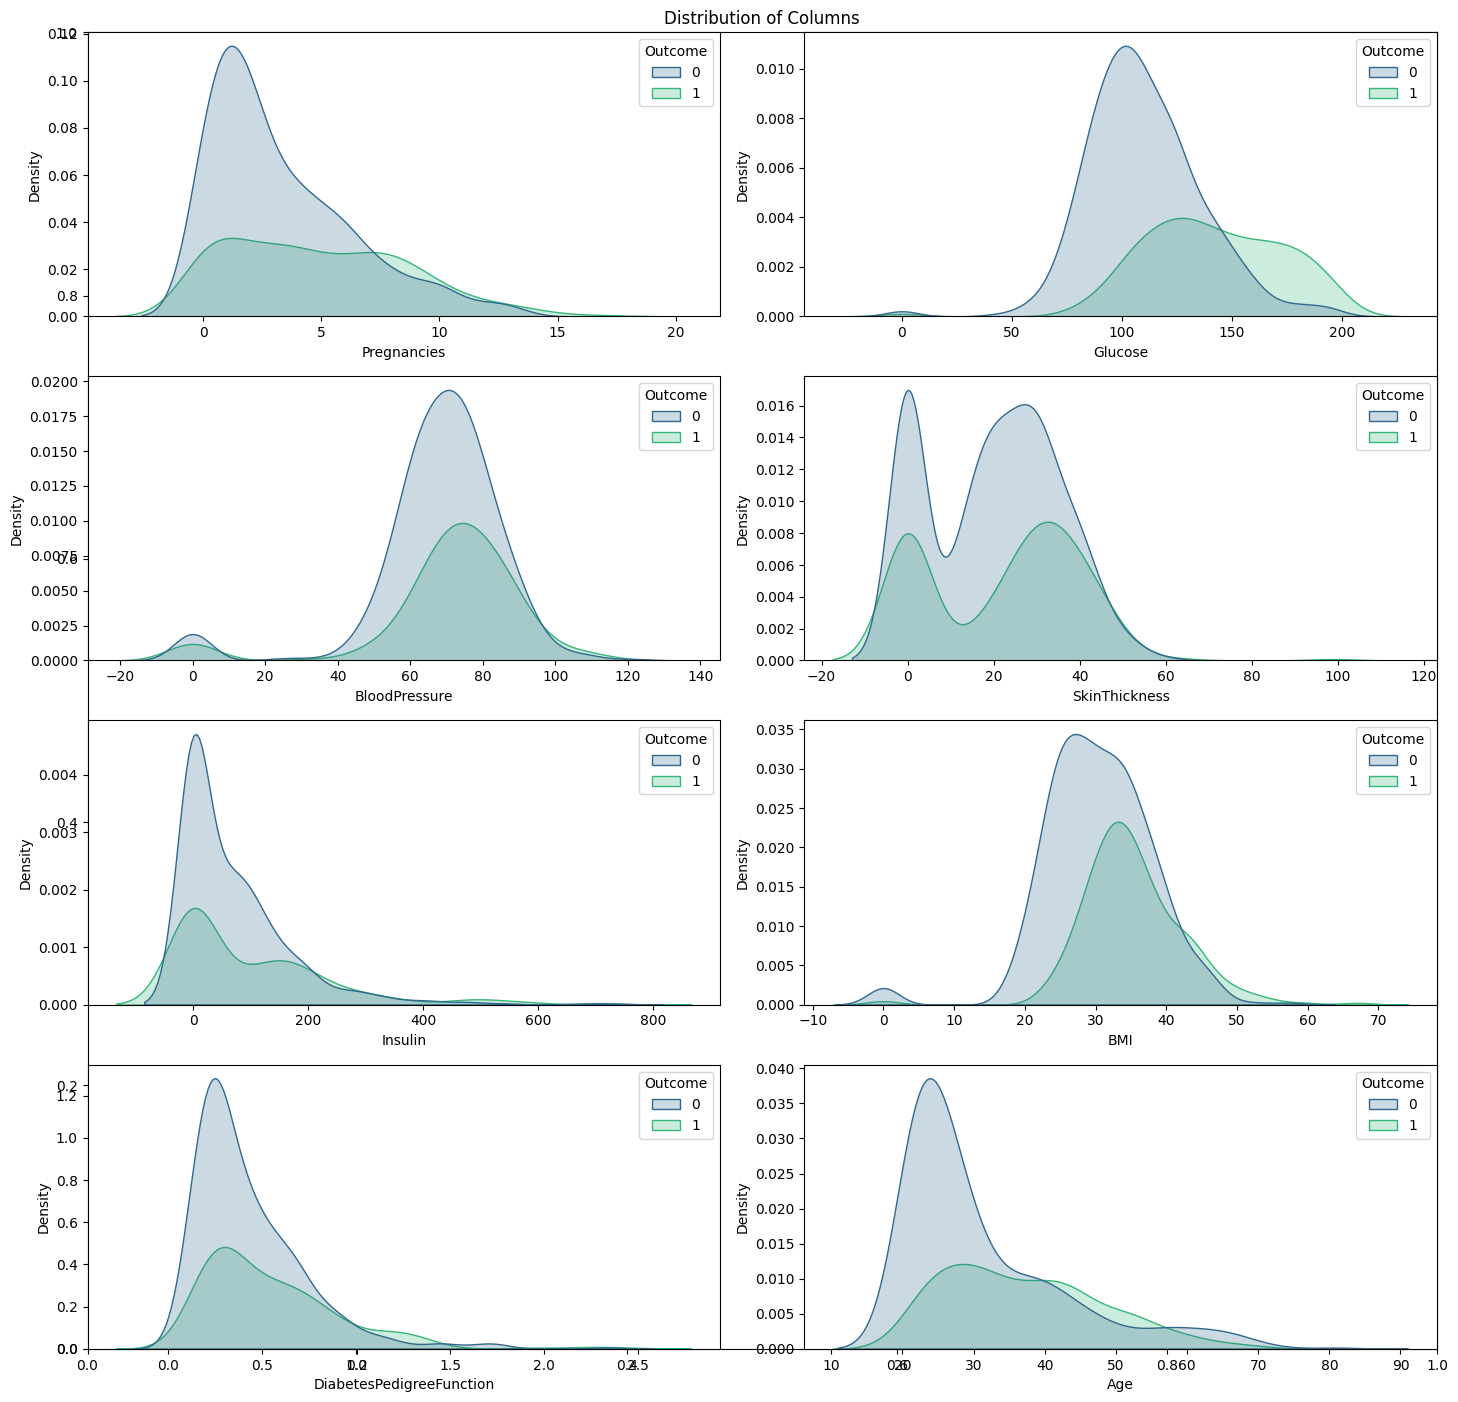

In [71]:
# loop over columns to show its distribution based on target  ( 1 or 0 )
plt.figure(figsize=(15,15))
plt.title('Distribution of Columns')
for i,col in zip(range(1,len(df.columns)),df.columns) :
    plt.subplot(4,2,i)
    sns.kdeplot(data=df, x=col, hue="Outcome", fill=True, palette="viridis")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Target variables

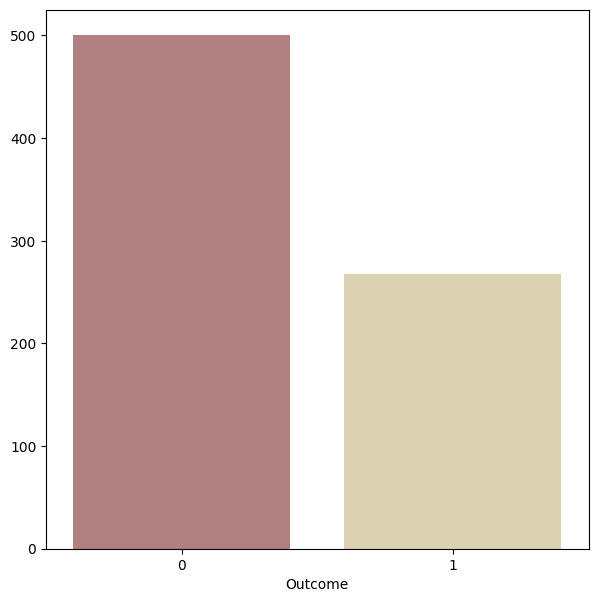

In [72]:
plt.figure(figsize=(7,7))
sns.barplot(x=df.Outcome.value_counts().index , y=df.Outcome.value_counts().values , palette='pink')
plt.show()

### 2.7 Outlier Analysis

In [73]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [74]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [75]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [76]:
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False
Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False
